In [2]:
# Import Packages
import pandas as pd
import numpy as np
import nltk 
from tqdm import tqdm
import re
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [3]:
# Import Data
path = '/Users/kritchanwong/Downloads/Plato-project-5001-main'
TOKEN = pd.read_csv(path + '/data_out/' +'token_plato.csv')
TOKEN['term_str']=TOKEN['token_str'].str.lower().str.replace('[\W_]', '') #Making into term string
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

/var/folders/3f/42p6mrgd1jj65bcnbf2ztbkc0000gn/T/ipykernel_32501/1415309324.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  TOKEN['term_str']=TOKEN['token_str'].str.lower().str.replace('[\W_]', '') #Making into term string


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/3f/42p6mrgd1jj65bcnbf2ztbkc0000gn/T/ipykernel_32501/4162230426.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  .drop('topic_id',1)['term_str'])
/var/folders/3f/42p6mrgd1jj65bcnbf2ztbkc0000gn/T/ipykernel_32501/4162230426.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  .drop('topic_id',1)['term_str'])
/var/folders/3f/42p6mrgd1jj65bcnbf2ztbkc0000gn/T/ipykernel_32501/4162230426.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the a

topic_weight
book_id chap_num para_num topic_id              
Apology 1        0        6             0.109551
                          11            0.059877
                          21            0.175103
                          29            0.465456
                          32            0.146385
...                                          ...
Timaeus 1        124      30            0.174721
                          33            0.068270
                          37            0.127384
                 125      16            0.724984
                          31            0.188652

[48019 rows x 1 columns]

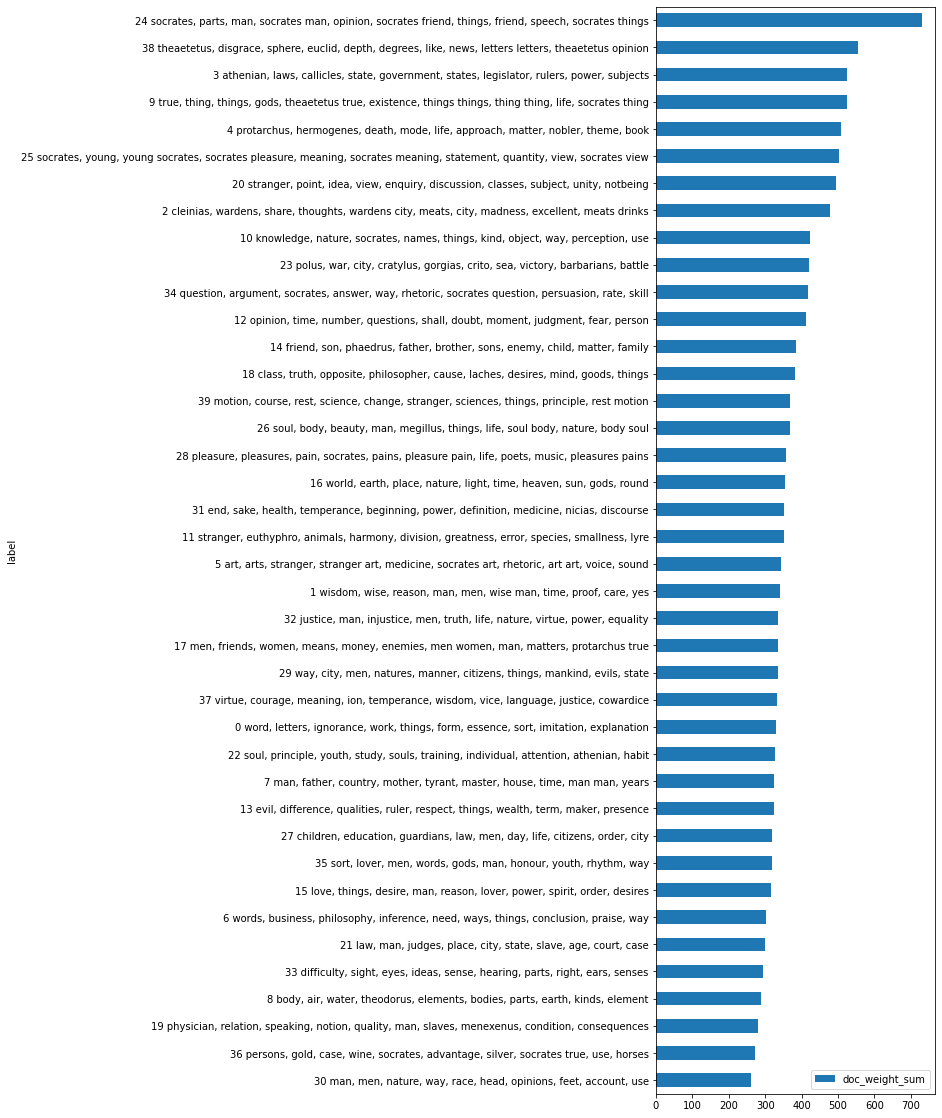

In [4]:
# Performing Topic Modelling
##Configuring Parameters
ngram_range = [1,2]
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 10

# Creating a DOC
DOCS = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO[:3]).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'}) 

# Using LDA
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names()
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0) #LDA


# Creating THETA and PHI tables
THETA = pd.DataFrame(lda_engine.fit_transform(count_model), index=DOCS.index)
THETA.columns.name = 'topic_id' #Theta Table
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str' #PHI Table

# Topic Tables
TOPICS = PHI.stack().to_frame().rename(columns={0:'topic_weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
        x.sort_values('topic_weight', ascending=False)\
               .head(n_top_terms)\
               .reset_index()\
               .drop('topic_id',1)['term_str'])

TOPICS[[t for t in range(n_top_terms)]]
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ', '.join(x[:n_top_terms]), 1) #Label

# Sorting Topics
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,n_topics/2));


# Topics by Docs
TOPICS['top_docs'] = THETA.idxmax(1).value_counts().sort_index()
TOPICS[['label','top_docs']].sort_values('top_docs', ascending=False)
topic_weight_thresh = lda_engine.doc_topic_prior_
X = THETA * (THETA >= topic_weight_thresh).astype('int')
DOCTOPICS = pd.DataFrame(X.stack()[X.stack() > 0], columns=['topic_weight'])